# Reference: 
### https://github.com/rakeshranjan001/Movie-Recommendation-System-Collaborative-filtering-MovieLens-100k-/blob/master/Python%20Code.py

In [69]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation
import matplotlib.pyplot as plt
import random

from sklearn.metrics import mean_squared_error

In [17]:
#Loading movielens data
#Ratings
rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('data_files/u.data', sep='\t', names=rating_cols)

#Movies
movie_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', "unknown", "Action", "Adventure", "Animation", "Children's",
"Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir","Horror", "Musical", " Mystery", "Romance", "Sci-Fi", "Thriller",
"War","Western"]
movies = pd.read_csv('data_files/u.item', sep='|', names=movie_cols, encoding='latin-1')

In [18]:
movies

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
genre = []
for index, row in movies.iterrows():
    tmp = []
    n = 0
    for d in row:
        if d == 1:
            tmp.append(movie_cols[n])
        n=n+1
    if 'movie_id' in tmp:
        tmp.remove('movie_id')
    genre.append('|'.join(tmp))

In [20]:
movies.insert(loc=5, column='genres', value=genre)
movies.drop(["video_release_date","unknown", "Action", "Adventure", "Animation", "Children's",
"Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir","Horror", "Musical", " Mystery", "Romance", "Sci-Fi", "Thriller",
"War","Western"], axis='columns', inplace=True)

In [21]:
movies

,movie_id,title,release_date,imdb_url,genres
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,Action|Adventure|Thriller
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,Thriller
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,Action|Comedy|Drama
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),Crime|Drama|Thriller
...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,Drama
1678,1679,B. Monkey (1998),06-Feb-1998,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,Romance|Thriller
1679,1680,Sliding Doors (1998),01-Jan-1998,http://us.imdb.com/Title?Sliding+Doors+(1998),Drama|Romance
1680,1681,You So Crazy (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?You%20So%20Cr...,Comedy


In [22]:
#Merging movie data with their ratings
movie_ratings = pd.merge(movies, ratings)

In [26]:
movie_ratings

,movie_id,title,release_date,imdb_url,genres,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy,66,3,883601324
...,...,...,...,...,...,...,...,...
99995,1678,Mat' i syn (1997),06-Feb-1998,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,Drama,863,1,889289570
99996,1679,B. Monkey (1998),06-Feb-1998,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,Romance|Thriller,863,3,889289491
99997,1680,Sliding Doors (1998),01-Jan-1998,http://us.imdb.com/Title?Sliding+Doors+(1998),Drama|Romance,863,2,889289570
99998,1681,You So Crazy (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?You%20So%20Cr...,Comedy,896,3,887160722


In [ ]:
#pre-processing
#dropping colums that aren't needed
ratings.drop( "timestamp", inplace = True, axis = 1 ) 
movies.drop(movies.columns[[3,4]], inplace = True, axis = 1 )

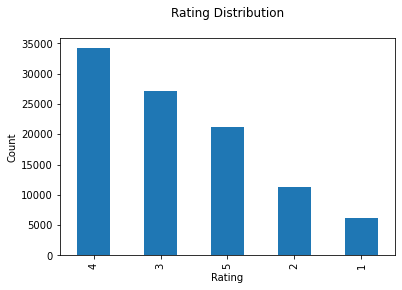

In [27]:
plt.rc("font", size=10)
movie_ratings.rating.value_counts(sort=True).plot(kind='bar')
plt.title("Rating Distribution\n")
plt.xlabel('Rating')
plt.ylabel('Count')
# plt.savefig('system1.png', bbox_inches='')
plt.show()

In [23]:
#Pivot Table(This creates a matrix of users and movie_ratings)
ratings_matrix = ratings.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_matrix.fillna( 0, inplace = True )

In [24]:
ratings_matrix

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
1,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
#Cosine Similarity(Creates a cosine matrix of similaraties ..... which is the pairwise distances between two items )

movie_similarity = 1 - pairwise_distances( ratings_matrix.values, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) 
ratings_matrix = pd.DataFrame( movie_similarity )

In [29]:
ratings_matrix

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,0.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
1,0.402382,0.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
2,0.330245,0.273069,0.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
3,0.454938,0.502571,0.324866,0.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
4,0.286714,0.318836,0.212957,0.334239,0.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.000000,0.000000
1678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.000000,0.000000
1679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.000000,0.000000
1680,0.047183,0.078299,0.000000,0.056413,0.000000,0.000000,0.051498,0.082033,0.057360,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [36]:
movie_ids = ratings_matrix.index
movie_list = list(movie_ids)
type(movie_list)

list

In [46]:
movie_id = random.choice(movie_list)
print(movie_id)
movie_title = movie_ratings.title[7]
print(movie_title)

444
Toy Story (1995)


In [43]:
def get_movie_title():
    movie_id = random.choice(movie_list)
    movie_title = movie_ratings.title[movie_id]
    return movie_title

In [70]:
#Recommender
flag = True
try:
    user_input = get_movie_title()
    inp=movies[movies['title']==user_input].index.tolist()
    inp=inp[0]
    
    movies['similarity'] = ratings_matrix.iloc[inp]
    movies.columns = ['movie_id', 'title', 'release_date', 'imdb_url', 'genres','similarity']
    movies.head(5)
    
except Exception as e:
    flag = False
    if str(e) == 'list index out of range':
        print("Sorry, the movie is not in the database!")
    else:
        print(e)
        print("__________________________________________________________________________________")
        
if flag:
    print("Recommended movies based on your choice of ",user_input ,":")
    predicted = movies.sort_values( ["similarity"], ascending = False )
    print(movies.sort_values( ["similarity"], ascending = False )[:5])

Recommended movies based on your choice of  Twelve Monkeys (1995) :
     movie_id                      title release_date  \
99        100               Fargo (1996)  14-Feb-1997   
49         50           Star Wars (1977)  01-Jan-1977   
116       117           Rock, The (1996)  07-Jun-1996   
55         56        Pulp Fiction (1994)  01-Jan-1994   
180       181  Return of the Jedi (1983)  14-Mar-1997   

                                              imdb_url  \
99     http://us.imdb.com/M/title-exact?Fargo%20(1996)   
49   http://us.imdb.com/M/title-exact?Star%20Wars%2...   
116  http://us.imdb.com/M/title-exact?Rock,%20The%2...   
55   http://us.imdb.com/M/title-exact?Pulp%20Fictio...   
180  http://us.imdb.com/M/title-exact?Return%20of%2...   

                                  genres  similarity  
99                  Crime|Drama|Thriller    0.690951  
49   Action|Adventure|Romance|Sci-Fi|War    0.653299  
116            Action|Adventure|Thriller    0.643701  
55                  

In [ ]:
rmse = mean_squared_error(y_actual, y_predicted, squared=False)